**Pouya Sadeghi**

winter-1401(2022)

# AI course, project #4

**Machine Learning**

# 00. Problem Description

## Dataset Introduction

|Column|Description|
|--|--|
|Pregnancies|The number of times that a person is pregnant|
|Glucose|Blood Glucose level|
|BloodPressure|blood pressure|
|SkinThickness|skin thickness|
|Insulin|The level of Insulin in that person's blood|
|BMI|Body Mass Index|
|DiabetesPedigreeFunction|Risk of type 2 diabetes|
|Age|age|
|Outcome|Does the person have diabetes or not?|

## Initialization

In [1]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay, 
    accuracy_score, precision_score, recall_score, f1_score
    )
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
DATASET_FILE = "diabetes.csv"
High_CORRELATION_THRESHOLD = 0.15
TEST_PORTION = 0.1

In [6]:
diabetes = pd.read_csv(DATASET_FILE)

# 01. Phase1: EDA

## 01. examine structure of data

In [7]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               635 non-null    float64
 1   Glucose                   654 non-null    float64
 2   BloodPressure             680 non-null    float64
 3   SkinThickness             624 non-null    float64
 4   Insulin                   680 non-null    float64
 5   BMI                       684 non-null    float64
 6   DiabetesPedigreeFunction  590 non-null    float64
 7   Age                       655 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [8]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,635.000000,654.000000,680.000000,624.000000,680.000000,684.000000,590.000000,655.000000,768.000000
mean,3.700787,113.422018,68.786765,20.386218,80.123529,32.083626,0.466676,33.157252,0.348958
std,3.518126,202.816831,19.724841,15.987049,115.681140,7.800741,0.322408,13.829831,0.476951
min,-22.000000,-5000.000000,-2.000000,0.000000,0.000000,0.000000,0.078000,-150.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.375000,0.243250,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,34.000000,32.300000,0.368000,29.000000,0.000000
75%,6.000000,140.750000,80.000000,32.000000,129.250000,36.600000,0.611500,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.329000,81.000000,1.000000


## 02. lost values per label

In [9]:
def get_lost_values(df: pd.DataFrame):
    total_entities = len(df)
    labels_nan = df.isna().sum()
    labels_nan_percent = (labels_nan / total_entities) * 100
    return pd.DataFrame({
        'Label':labels_nan.index, 
        'Number':labels_nan.values, 
        'Percent':labels_nan_percent.values
        })
lost_values = get_lost_values(diabetes)
lost_values

,Label,Number,Percent
0,Pregnancies,133,17.317708
1,Glucose,114,14.843750
2,BloodPressure,88,11.458333
3,SkinThickness,144,18.750000
4,Insulin,88,11.458333
5,BMI,84,10.937500
6,DiabetesPedigreeFunction,178,23.177083
7,Age,113,14.713542
8,Outcome,0,0.000000


## 03. Dependency diagram of features

We use correlation matrix in two ways:
- correlation heatmap with all features
- pairwise relationship between features

### Pairwise

Correlation of outcome with Pregnancies: 19.331%
Correlation of outcome with Glucose: 10.552%
Correlation of outcome with BloodPressure: 4.480%
Correlation of outcome with SkinThickness: 8.617%
Correlation of outcome with Insulin: 11.224%
Correlation of outcome with BMI: 28.437%
Correlation of outcome with DiabetesPedigreeFunction: 18.696%
Correlation of outcome with Age: 15.290%


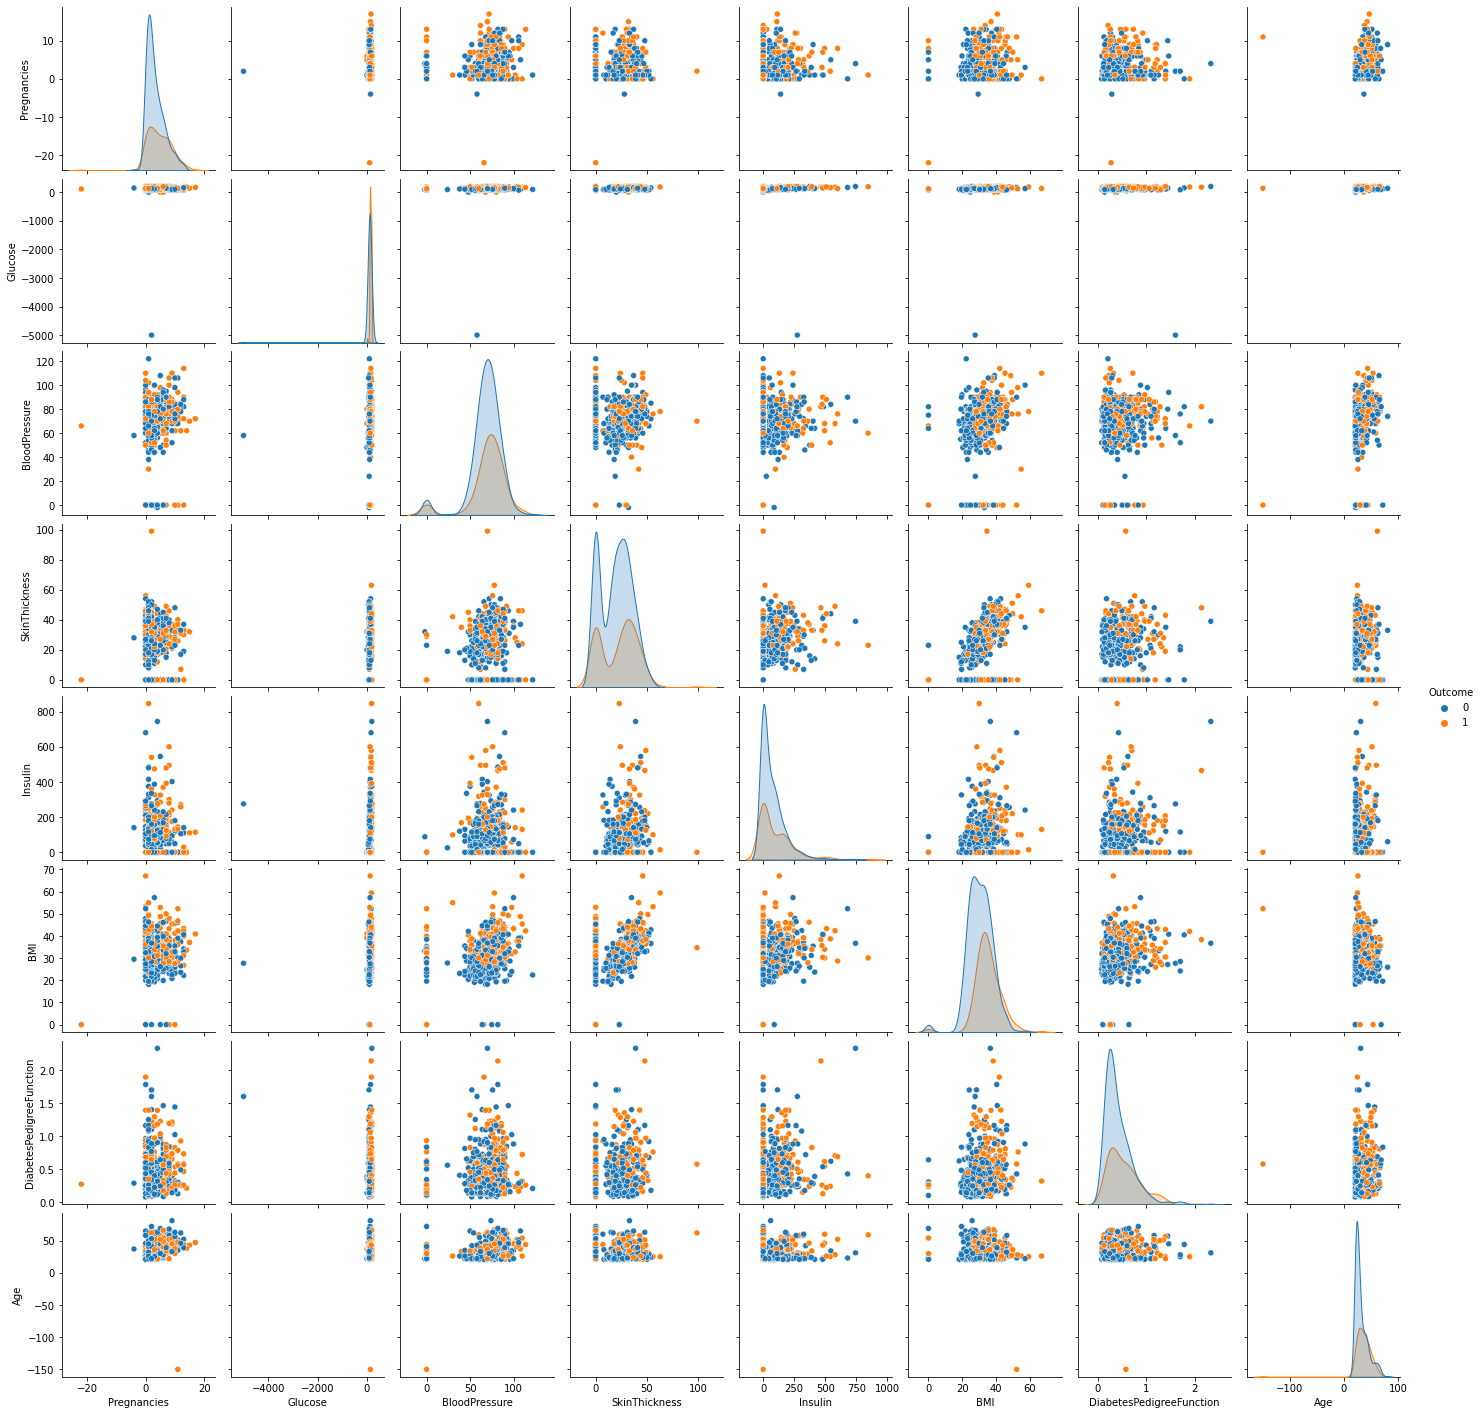

In [10]:
def pairwise_examination(df: pd.DataFrame):
    labels = df.columns.values
    for label in labels:
        if label == 'Outcome':
            continue
        y, x = df['Outcome'], df[label]
        correlation = x.corr(y)
        print(f"Correlation of outcome with {label}: {100 * correlation:.3f}%")
        # plt.title(f'Correlation / {label}')
        # plt.scatter(x, y)
        # plt.plot(
        #     np.unique(x), 
        #     np.poly1d(np.polyfit(x, y, 1))
        #     (np.unique(x)), color='red')
        # plt.xlabel(label)
        # plt.ylabel('outcome')
        # plt.show()
    sns.pairplot(df, hue='Outcome')
pairwise_examination(diabetes)

### Correlation

In [11]:
corr = diabetes.corr()
plt.figure(figsize=(15, 10))
# sns.heatmap(
#     corr, 
#     cmap=sns.diverging_palette(220, 25, as_cmap=True), 
#     square=True,
#     annot=True,
#     )
corr.style.background_gradient(
    cmap='coolwarm', 
    axis=None
    ).format(precision=3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.041,0.156,-0.099,-0.072,0.080,-0.024,0.403,0.193
Glucose,0.041,1.000,0.047,0.088,-0.022,0.058,-0.134,0.197,0.106
BloodPressure,0.156,0.047,1.000,0.212,0.084,0.239,0.042,0.281,0.045
SkinThickness,-0.099,0.088,0.212,1.000,0.417,0.404,0.168,-0.128,0.086
Insulin,-0.072,-0.022,0.084,0.417,1.000,0.182,0.209,-0.018,0.112
BMI,0.080,0.058,0.239,0.404,0.182,1.000,0.161,-0.053,0.284
DiabetesPedigreeFunction,-0.024,-0.134,0.042,0.168,0.209,0.161,1.000,0.049,0.187
Age,0.403,0.197,0.281,-0.128,-0.018,-0.053,0.049,1.000,0.153
Outcome,0.193,0.106,0.045,0.086,0.112,0.284,0.187,0.153,1.000


<Figure size 1080x720 with 0 Axes>

As we can see, `BMI`, `Pregnancies`, `DiabetesPedigreeFunction`, and `Age` have high correlation with *Outcome*(*BMI* has the highest).

In [12]:
# labels with correlation >= .15 with Outcome
high_correlation = [
    (feature, correlation) for correlation, feature in zip(corr['Outcome'], corr['Outcome'].index) 
    if correlation >= High_CORRELATION_THRESHOLD and feature != 'Outcome']
high_correlation.sort(key= lambda x: x[1], reverse=True)

## 04. Plot frequency of each value for labels with high correlation


In [13]:
feature_with_high_correlation = [f for f, c in high_correlation]

array([[<AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'Pregnancies'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>]], dtype=object)

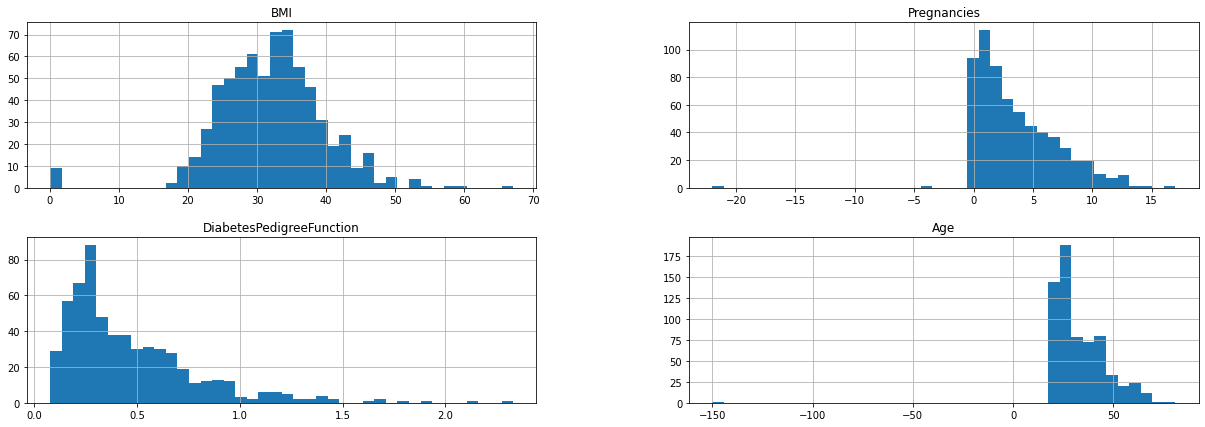

In [14]:
diabetes.hist(figsize=(21, 7), bins=40, column=feature_with_high_correlation)

## 05. examine relations with outcome(you could use *hexbin* and *scatter*)

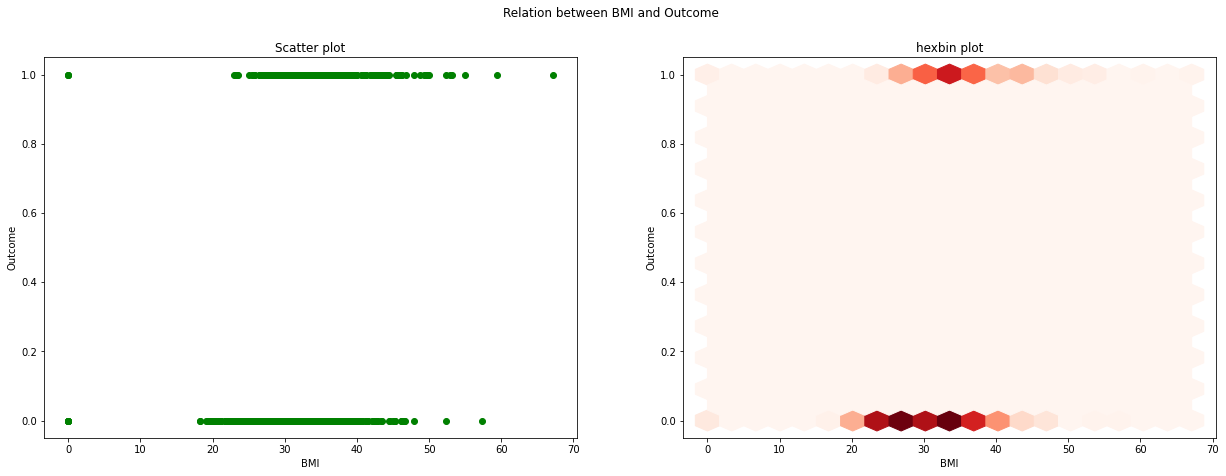

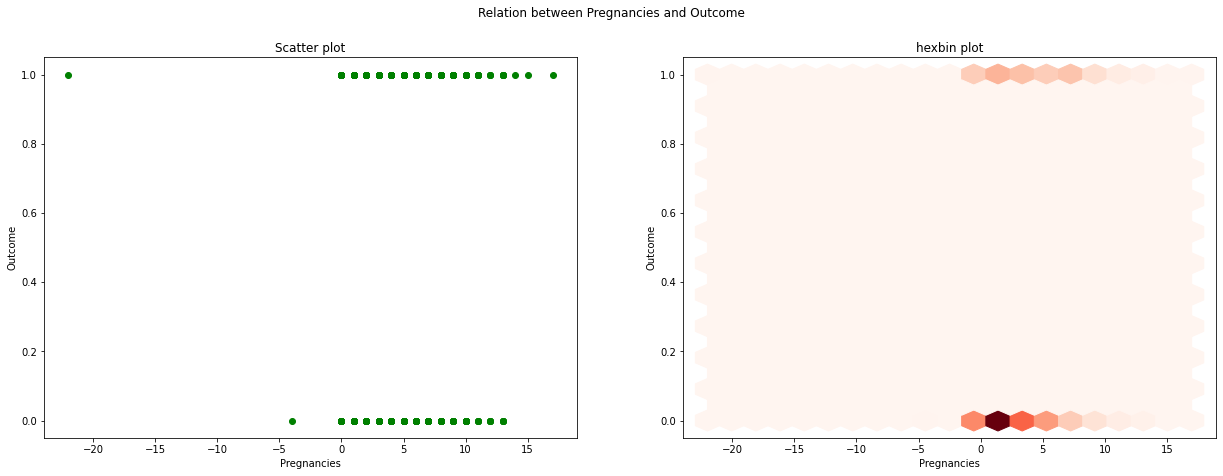

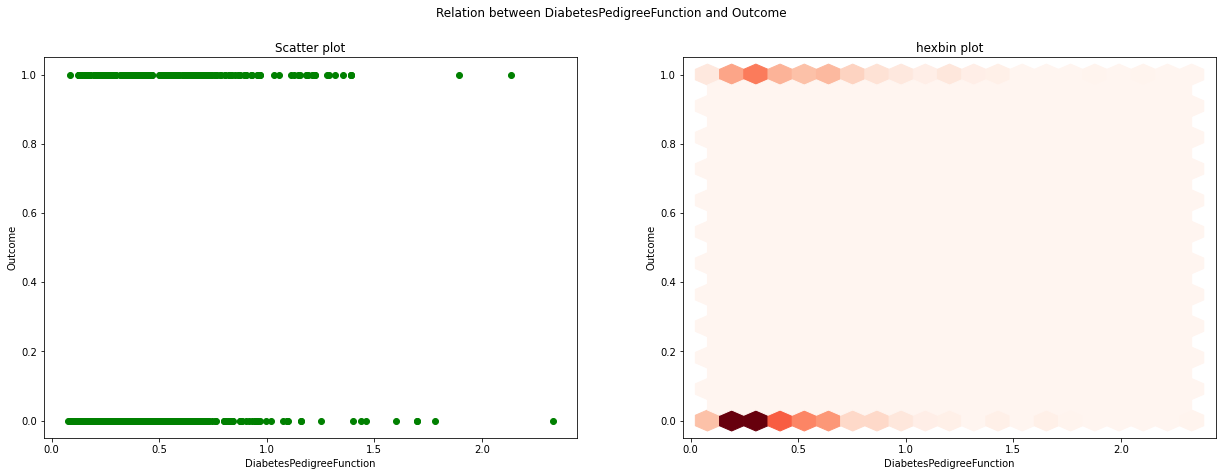

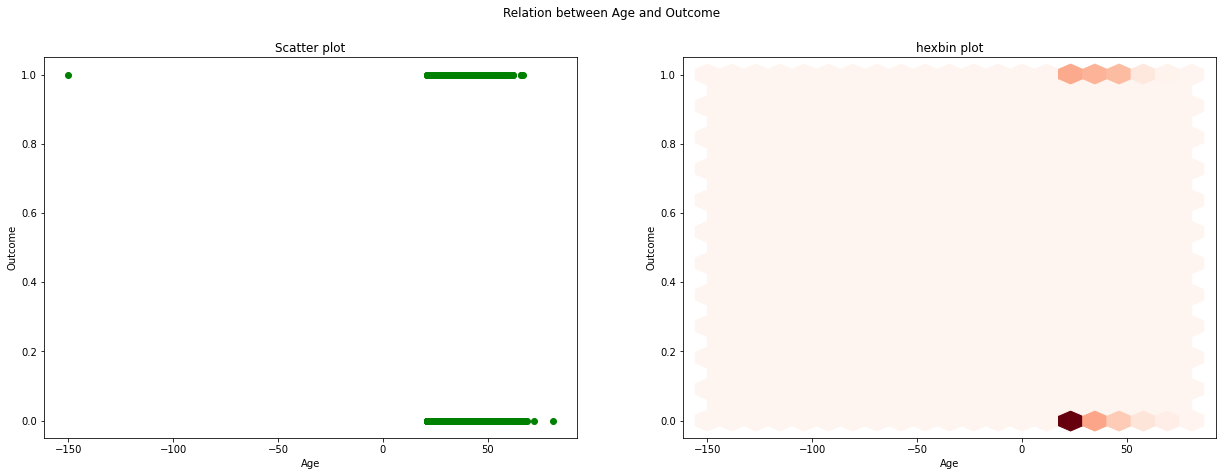

In [15]:
def rl_plot(df: pd.DataFrame, label):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21,7))
    fig.suptitle(f"Relation between {label} and Outcome")
    for i in [0,1]:
        ax[i].set_xlabel(label)
        ax[i].set_ylabel('Outcome')
    ax[0].set_title(f"Scatter plot")
    ax[0].scatter(x=df[label], y=df['Outcome'], c='green')
    
    ax[1].set_title(f"hexbin plot")
    ax[1].hexbin(df[label], df['Outcome'], gridsize=20, cmap='Reds')
    plt.show()
    
for f in feature_with_high_correlation:
    rl_plot(diabetes, f)

As we can see, `hexbin plot` gives us clearer information about the relation between each *feature* and *outcome*
some of them are:
- BMI:
    1. a large of people have $BMI \in [22,38]$.
    2. There is a high chance of diabetes for people with $BMI \in [28,38]$.
- Pregnancies:
    1. most people have had *0 to 4* pregnancies.
- DiabetesPedigreeFunction:
    1. A high number of people with a $DiabetesPedigreeFunction \in [0.1, 0.4]$ have diabetes.
- Age:
    1. lower age could lead to lower risk of diabetes.
    2. most of the people in this dataset are older than 20 and younger than 50.

## 06. try other approaches that could help you to get more familiar with dataset.

Here are some point about out dataset:
1. we have noises in out dataset, like: Age = -150
2. some columns have strong correlation with each other: $\{(SkinThickness,Insulin), (Pregnancies,Age), ...\}$.
    we can use them for estimating lost values.
3. we can also check for `Outcome` distribution:
    - it's imbalance!
    - later, we would use SMOTE for over-sampling

<AxesSubplot:title={'center':'Number of samples per label'}>

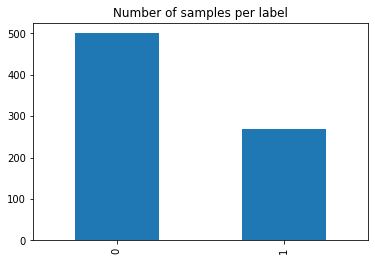

In [16]:
labels_freq = diabetes['Outcome'].value_counts()
labels_freq.plot(
    kind='bar', 
    title='Number of samples per label',
    )

# 02. Phase2: Preprocessing data

## 01. explain and compare ways to handle missing values in ML.


1. **deleting rows/columns with missing values**:
- Explanation:
    - if a column has more than half of the rows as null, then that column can be dropped entirely.
    - if a row has one or more columns values as null, then that row can be dropped.
- Pros:
    - easy to use and implement
    - It can lead to the creation of a robust model
- Cons:
    - we may lose a lot of out information
    - if it includes a large percentage of the dataset, it works poorly
***    

2. **impute missing values with statistics**:
- Explanation:
    - we can use *mean*,*median*,*mode* of remaining values in column to replace with missed values.
    - if the variable is categorical(string/numeric) missing values should be replaced with 
    the most frequent category of column.
    - there are other methods, such as LOCF(Last observation carried forward-*ffil*), 
    using in interpolation(*linear*), and etc.
    - as another approach, you may replace missing values with zero/constant.
- Pros:
    - prevent data loss(saving rows and columns of data)
    - easy to implements
    - works fine for small datasets
- Cons:
    - only for numeric variables(in some case, numerical continuous)
    - could change variance and standard deviation
    - may cause data leak
    - may lead to poor performance
***

3. **using algorithms that support missing values**:
- Explanation:
    - as an example, Naive Bayes and K-NN algorithms, could design to handle missing values in prediction.
- Pros:
    - we don't need to handle missing values, ML algorithms will handle them for us
- Cons:
    - you can't find such algorithms in the scikit-learn library :))
***

4. **impute missing values using Deep Learning Library(Datawig)**:
- Explanation:
    - just giving your data to the model, fit, and then predict the missing values
- Pros:
    - optimized for both CPU and GPU
    - more accurate than others
- Cons:
    - as is uses ML approaches, ith might be slow for large datasets
***

5. **predict missing values**:
- Explanation:
    - we can use classification or regression for this purpose.
- Pros:
    - considering covariance and taking advantage of it
- Cons:
    - nothing more than a proxy for true values
    - if we have a large amount of Nan, could cause bias
***

## 02. fix missing values.

As you can see below, `DiabetesPedigreeFunction`, `SkinThickness`, and `Pregnancies` have the most missing values.

We design a pipeline for dealing with missing values.

In [17]:
lost_values

,Label,Number,Percent
0,Pregnancies,133,17.317708
1,Glucose,114,14.843750
2,BloodPressure,88,11.458333
3,SkinThickness,144,18.750000
4,Insulin,88,11.458333
5,BMI,84,10.937500
6,DiabetesPedigreeFunction,178,23.177083
7,Age,113,14.713542
8,Outcome,0,0.000000


In [18]:
def solve_missing_values(_df: pd.DataFrame, loss_values_stats: pd.DataFrame, del_threshold: float = 0.5, restricted_col=['Outcome']):
    mean_kind = ['i', 'f']
    mode_kind = ['O']
    df = _df.copy(deep=True)
    for label, percent in zip(loss_values_stats['Label'], loss_values_stats['Percent']):
        if percent == 0 or label in restricted_col:
            continue
        elif percent >= del_threshold * 100:
            df.drop(label, axis=1, inplace=True)
        elif df[label].dtype.kind in mean_kind:
            df[label].fillna(df[label].mean(), inplace=True)
        elif df[label].dtype.kind in mode_kind:
            df[label].fillna(df[label].mode()[0], inplace=True)
            
    return df

In [19]:
diabetes_nan_fixed = solve_missing_values(diabetes, lost_values)

## 03. why we use normalization for numeric data types?

Feature Scaling is one of the most important data preprocessing step in ML.
Tree-based algorithms are fairly insensitive to the scale of the features.
Also, this helps algorithms to converge faster.
Normalization and Standardization are the most popular algorithms in this area:

- Normalization(also called Min-Max Scaling): a scaling technique in which values are shifted and rescaled so at the end, values are in range $[0,1]$ or sometimes $[-1,1]$.
    - used to transform features to be on a similar scale(used when features are of different scales)
    - affected by outliers
    - useful when we don’t know about the distribution
    - it defines as $$x_i = \frac{x_i - min(X)}{max(X) - min(X)}$$


- Standardization(also known as Z-Score Normalization): a scaling technique where the values are centered around the mean with a unit standard deviation(mean=0, std=1).
    - can be helpful where the data follows a Gaussian distribution
    - not bounded to a certain range
    - can reduce outliers effect
    - useful when the feature distribution is Normal or Gaussian
    - it defines as $$x_{i} = \frac{x_{i} - mean(X)}{StandardDeviation(X)}$$

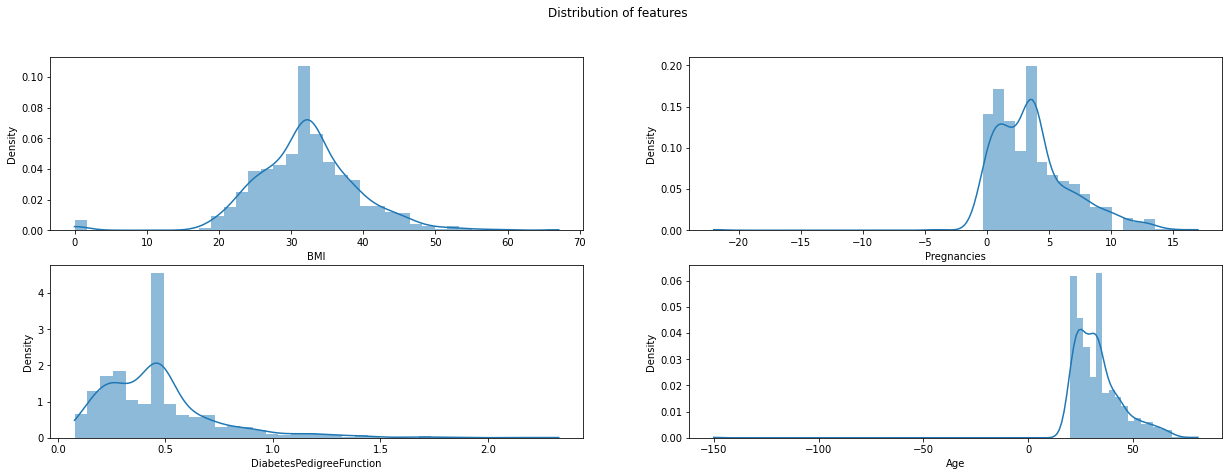

In [20]:
def plot_distribution(df, labels):
    fig, ax = plt.subplots(nrows=(len(labels)+1)//2, ncols=2, figsize=(21,7))
    fig.suptitle(f"Distribution of features")
    i, j = 0, 0
    for l in labels:
        sns.histplot(df[l], ax=ax[i][j], kde=True, stat="density", linewidth=0)
        i += j
        j = 1 - j
    plt.show()

plot_distribution(diabetes_nan_fixed, feature_with_high_correlation)

We use Standardization scaling because of Normal distribution.

## 03.2. noise values

It's clear than negative values are just noises in out dataset, let's delete them before continue.

If we check out data with more precision, we could guess that also $BMI <= 10$ would be noise value too(but we won't).

In [21]:
# count noise values for each column
for col in diabetes.columns:
    noise_count = (diabetes[col] < 0).sum()
    print(f"Number of noises in {col} column: {noise_count}")
    if noise_count > 0:
        diabetes = diabetes.drop(diabetes[diabetes[col] < 0].index, axis=0)
print("By noise, we mean negative values as they aren't valid in our dataset.")

Number of noises in Pregnancies column: 2
Number of noises in Glucose column: 1
Number of noises in BloodPressure column: 1
Number of noises in SkinThickness column: 0
Number of noises in Insulin column: 0
Number of noises in BMI column: 0
Number of noises in DiabetesPedigreeFunction column: 0
Number of noises in Age column: 1
Number of noises in Outcome column: 0
By noise, we mean negative values as they aren't valid in our dataset.


## 04. how could you preprocess object/str data types?

At first, we would turn categorical values into numeric values(encoded to numerical values).
we can achieve this with these two methods:
- LabelEncoder: assigns a number to each categorical value 
    - better not to use if we have more than two category
- OneHotEncoder: basically creates 0 and 1 for each category. it will add several columns or use matrix and assigns zeroes and one to them based on category
    - works fine if we have more than two category

We don't need to use this approaches for all columns with type str/object. 
actually, we need to drop some columns such as *name*.
in such cases, all values could be unique and they won't help our model.

**Attention**: in some cases, such categories mentioned above could be useful, but as they can act as an identifier, they could let to ***Overfitting*** model.

In [22]:
def standardize_df(_df: pd.DataFrame, restricted=[]):
    numeric_scaler = StandardScaler()
    one_hot_encoder = OneHotEncoder(sparse=False)
    label_encoder = LabelEncoder()
    df = _df.copy(deep=True)
    for l in df.columns:
        if l in restricted:
            continue
        if df[l].dtype.kind == 'O':
            categories = df[l].unique()
            if categories <= 2:
                df[l] = label_encoder.fit_transform(df[l].values.reshape(-1, 1))
            elif categories >= 200:
                df.drop(l, axis=1, inplace=True)
            else:
                df[l] = one_hot_encoder.fit_transform(df[l].values.reshape(-1, 1))
            continue
        if df[l].dtype.kind in ['i', 'f']:
            df[l] = numeric_scaler.fit_transform(df[l].values.reshape(-1, 1))
            continue
    return df

In [23]:
diabetes_standardized = standardize_df(diabetes_nan_fixed, restricted=['Outcome'])
diabetes_standardized.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,768.000000
mean,2.729298e-16,4.625929e-18,2.266705e-16,-2.752428e-16,-2.544261e-17,2.012279e-16,6.938894e-18,1.850372e-16,0.348958
std,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,0.476951
min,-8.040278e+00,-2.734209e+01,-3.816667e+00,-1.415810e+00,-7.366195e-01,-4.361319e+00,-1.376594e+00,-1.435156e+01,0.000000
25%,-8.449189e-01,-6.642204e-02,-2.580919e-01,-7.213162e-01,-7.366195e-01,-5.822988e-01,-7.213702e-01,-6.391735e-01,0.000000
50%,2.778593e-16,0.000000e+00,6.541499e-02,-2.467337e-16,-1.896034e-01,0.000000e+00,0.000000e+00,-9.067817e-02,0.000000
75%,4.064479e-01,1.207272e-01,4.967574e-01,6.676710e-01,3.206385e-01,5.085873e-01,2.402146e-01,4.578171e-01,1.000000
max,4.160548e+00,4.575958e-01,2.869141e+00,5.459677e+00,7.041122e+00,4.759985e+00,6.595883e+00,3.748789e+00,1.000000


## 05. could you just drop some columns? why?

- We mentions some conditions for deleting columns, but due to our dataset structure and it's data, we don't really need to delete any column.
- Also, attention that our models won't necessary use all of features.

- Some cases:
    - we could drop columns with poor correlation with outcome(we try it later) $->$ because of poor corr
    - some columns could be exclusive like *Name* and can't help us, so we will delete these columns
    - maybe there is a lot of missing values $->$ we can't fill *Nan* and it is better to drop this column


## 06. how would you separate dataset into train and test?

We need to split a dataset into train and test sets to evaluate how well our machine learning model performs.
The train set is used to fit the model, and the statistics of the train set are known.
The second one is used for prediction and evaluating model.

We can split our dataset into train and test part:
- splitting dataset and assign one part as train and the other as test(stratified sampling)
    - - works fine with class imbalance datasets
- defining portion of each section and choose each sample randomly(random sampling)
    - works best for class balance datasets

Generally, we use libraries for this purpose:
- `train_test_split()` from `scikit-learn`
- `randn()` from `numpy`
- `sample()` from `pandas`
***

By splitting dataset into train and test, we can evaluate our model performance. for example, if training accuracy is extremely high, but the testing accuracy is poor, it would be a good sign of overfitting.

Splitting ratio is usually like $(Train, Test) \in [(0.8, 0.2), (0.75, 0.25), (\frac{2}{3}, \frac{1}{3})]$.
- We used $(.9, .1)$ for higher accuracy but it is better to use at least (.8, .2)$ so you could test your model in better and more reliable manner.

Splitting ratio would also depends on the number of samples we have in our dataset and the model we are training, for example:
- models with few hyperparameters: easy to validate and tune, so we can reduce the size of validation set. also you need more data for training
- if we have several hyperparameters to tune, our model requires larger validation set

To conclude:
- we use random sampling - the oldest and most known approach. it works best on class balanced(equal samples in each class) datasets

In [24]:
training_data, testing_data = train_test_split(diabetes_standardized, test_size=TEST_PORTION, random_state=11, stratify=diabetes_standardized['Outcome'])

x_train, y_train = training_data.drop(columns=['Outcome'], axis=1), training_data['Outcome']
x_test, y_test = testing_data.drop(columns=['Outcome'], axis=1), testing_data['Outcome']

In [25]:
sm = SMOTE(random_state = 2)
x_train, y_train = sm.fit_resample(x_train, y_train.ravel())

## 07. what is validation data?

Sometimes, we split the dataset into three parts: Train, Validation, Test.

Validation set(Development set): we use it to fine-tune the model hyperparameters. 
Model won't learn from this data and effects indirectly. 
We use the validation set results, to update higher level hyperparameters. 

Test set: once a model is completely trained(train and validation sets) to evaluate it's performance.
It is usually well curated and carefully sampled data that would cover various classes that the model would face in the real world usages. 

# Phase 3: Model Training, Evaluation and Hyper Parameter Tuning

## KNN model

As our values are continuous, we should use knn-regressor

In [28]:
def find_best_random_state(
    _model: callable, 
    x_train, y_train,
    x_test, y_test,
    states=range(1, 20),
    **config):
    """returns Model, (train_acc, test_acc), random_state"""
    best_state, best_acc, best_model = 0, (0, 0), None
    for rs in states:
        model = _model(random_state=rs, **config)
        model.fit(x_train, y_train)
        
        train_acc = accuracy_score(y_train, model.predict(x_train))
        y_pred = model.predict(x_test)
        test_acc = accuracy_score(y_test, y_pred)
        if test_acc > best_acc[1] or (test_acc == best_acc[1] and train_acc > best_acc[0]):
            best_model = model
            best_acc = (train_acc, test_acc)
            best_state = rs
            Y = y_pred
    return model, best_acc, best_state, Y

In [27]:
def generate_knn_model(x_train, y_train,x_test, y_test, k=range(1, 100, 2)):
    
    accuracy = []
    best_model, best_acc = None, (0,0)
    neighbors = list(k)
    
    for k in tqdm(neighbors, desc="Generating KNN model", leave=False):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(x_train, y_train)
        
        train_acc = accuracy_score(y_train, model.predict(x_train))
        test_acc = accuracy_score(y_test, model.predict(x_test))
        accuracy.append((train_acc, test_acc))
        
        acc = (train_acc, test_acc)
        if acc[1] > best_acc[1] or (acc[1 ]== best_acc[1] and acc [0] > best_acc[0]) or best_model is None:
            best_acc = acc
            best_model = model
            K = k
        
    
    plt.figure(figsize=(17,10))
    plt.title('Accuracy')
    plt.plot(neighbors, [acc[0] for acc in accuracy], label='Train')
    plt.plot(neighbors, [acc[1] for acc in accuracy], label='Test')
    plt.legend()
    plt.show()
    
    y_pred = best_model.predict(x_test)
    print(F"Generated model statistic:")
    print(f"- train acc: {100*best_acc[0]:.1f}%")
    print(f"- test acc: {100*best_acc[1]:.1f}%")
    print(f"- recall: {100*recall_score(y_test, y_pred):.1f}%")
    print(f"- precision: {100*precision_score(y_test, y_pred):.1f}%")
    print(f"- f1: {100*f1_score(y_test, y_pred):.1f}%")
    print("Config:")
    print(f"- K: {K}")
    
    confusion = confusion_matrix(y_test, y_pred)
    report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    sns.heatmap(
        report, 
        cmap=sns.diverging_palette(220, 25, as_cmap=True), 
        square=True,
        annot=True,
        robust=True,
        )
    return best_model, confusion

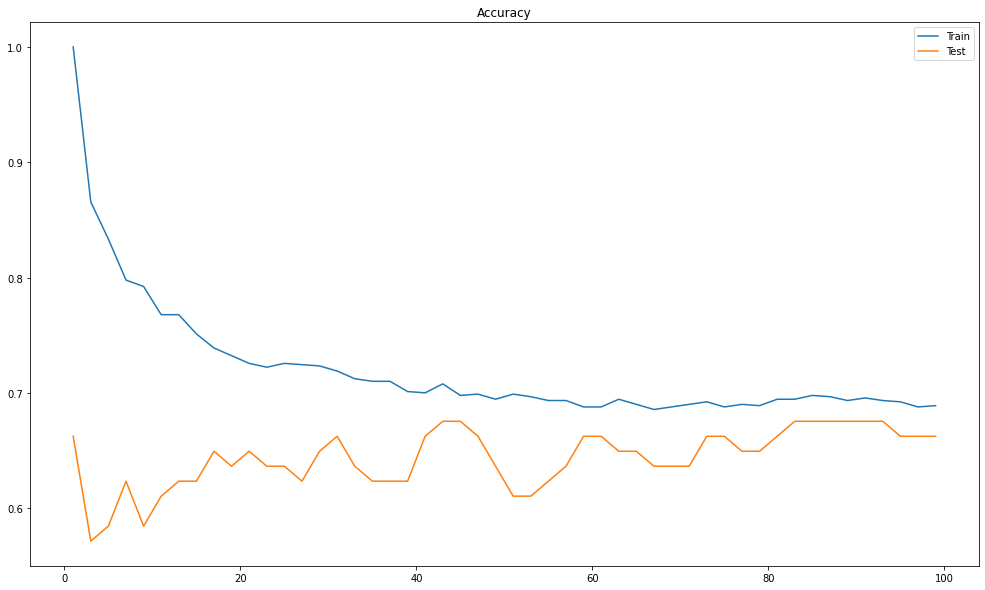

Generated model statistic:
- train acc: 70.8%
- test acc: 67.5%
- recall: 81.5%
- precision: 52.4%
- f1: 63.8%
Config:
- K: 43


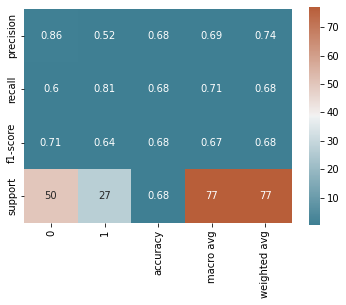

In [28]:
knn_model, knn_confusion = generate_knn_model(x_train, y_train,x_test, y_test)

## Decision Tree

In [51]:
def generate_DT_model(
    x_train, y_train,x_test, y_test,
    d=range(1, 80), 
    l=range(1, 20, 2),
    ):
    
    accuracy = []
    best_model, best_acc, best_rs = None, (0,0), 'unknown'
    depth_ranges = list(d)
    D = 'unknown'
    min_leaf_ranges = list(l)
    L = 'unknown'
    MF = 'default'
    IMP = 'default'
    
    m_features = ["sqrt", "log2", None]
    impurities = [0.05, 0.1]
    
    
    for d in tqdm(depth_ranges, desc="Generating Decision Tree model by Max-Depth", leave=False):
        iter_acc = (0,0)
        for mf in m_features:
            model, acc, rs, y = find_best_random_state(DecisionTreeClassifier, 
                                                    x_train, y_train, x_test, y_test, 
                                                    max_depth=d, criterion="entropy", max_features=mf)

            train_acc = acc[0]
            test_acc = acc[1]
            if test_acc > iter_acc[1]:
                iter_acc = (train_acc, test_acc)
                if test_acc > best_acc[1] or (test_acc == best_acc[1] and train_acc > best_acc[0]):
                    best_acc = acc
                    best_model = model
                    D = d
                    L = 'unknown'
                    best_rs = rs
                    MF = mf
                    IMP = 'default'
                    Y = y
                
            for l in min_leaf_ranges:
                model, acc, rs, y = find_best_random_state(DecisionTreeClassifier, 
                                                        x_train, y_train, x_test, y_test, 
                                                        max_depth=d, min_samples_leaf=l, 
                                                        criterion="entropy", max_features=mf)
            
                train_acc = acc[0]
                test_acc = acc[1]
                acc = (train_acc, test_acc)
                if test_acc > iter_acc[1]:
                    iter_acc = (train_acc, test_acc)
                    if test_acc > best_acc[1] or (test_acc == best_acc[1] and train_acc > best_acc[0]):
                        best_acc = acc
                        best_model = model
                        D = d
                        L = l
                        best_rs = rs
                        MF = mf
                        IMP = 'default'
                        Y = y
                        
            for imp in impurities:
                model, acc, rs, y = find_best_random_state(DecisionTreeClassifier, 
                                                    x_train, y_train, x_test, y_test, 
                                                    max_depth=d, criterion="entropy", 
                                                    max_features=mf, min_impurity_decrease=imp)
                train_acc = acc[0]
                test_acc = acc[1]
                acc = (train_acc, test_acc)
                if test_acc > iter_acc[1]:
                    iter_acc = (train_acc, test_acc)
                    if test_acc > best_acc[1] or (test_acc == best_acc[1] and train_acc > best_acc[0]):
                        best_acc = acc
                        best_model = model
                        D = d
                        L = 'unknown'
                        best_rs = rs
                        MF = mf
                        IMP = imp
                        Y = y
                    
                    
        accuracy.append(iter_acc)
        
    plt.figure(figsize=(17,10))
    plt.title('Accuracy')
    plt.plot(depth_ranges, [acc[0] for acc in accuracy], label='Train')
    plt.plot(depth_ranges, [acc[1] for acc in accuracy], label='Test')
    plt.xlabel('Max Depth')
    plt.legend()
    plt.show()
    
    y_pred = Y
    print(F"Generated model statistic:")
    print(f"- train acc: {100*best_acc[0]:.1f}%")
    print(f"- test acc: {100*best_acc[1]:.1f}%")
    print(f"- recall: {100*recall_score(y_test, y_pred):.1f}%")
    print(f"- precision: {100*precision_score(y_test, y_pred):.1f}%")
    print(f"- f1: {100*f1_score(y_test, y_pred):.1f}%")
    print("Config:")
    print(f"- Max Depth: {D}")
    print(f"- Min Samples Leaf: {L}")
    print(f"- Random State: {best_rs}")
    print(f"- Min Impurity Decrease: {IMP}")
    print(f"- Feature selection: {MF}")
    
    confusion = confusion_matrix(y_test, y_pred)
    report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    sns.heatmap(
        report, 
        cmap=sns.diverging_palette(220, 25, as_cmap=True), 
        square=True,
        annot=True,
        robust=True,
        )
    return best_model, confusion

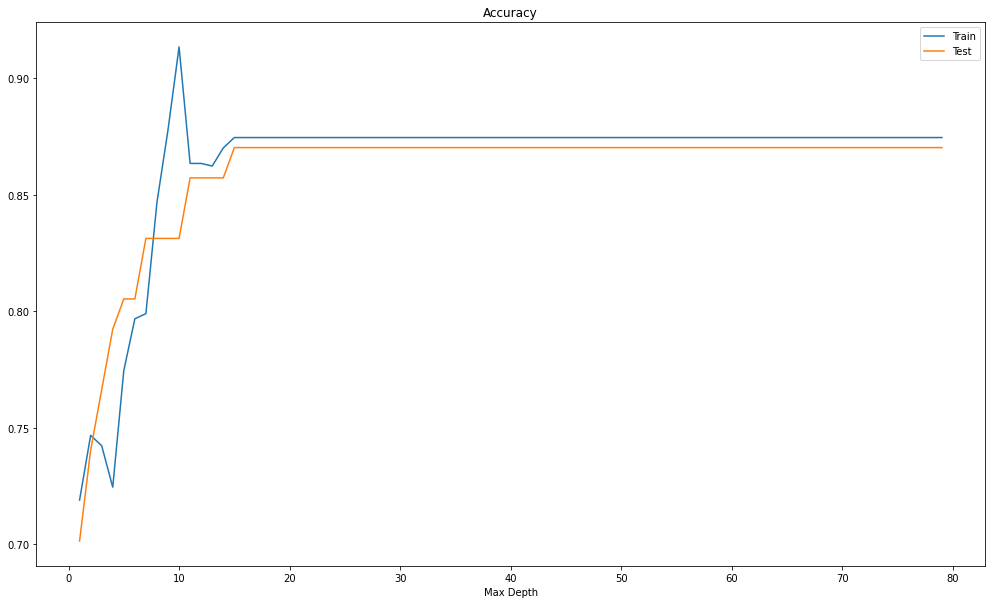

Generated model statistic:
- train acc: 87.4%
- test acc: 87.0%
- recall: 77.8%
- precision: 84.0%
- f1: 80.8%
Config:
- Max Depth: 15
- Min Samples Leaf: 5
- Random State: 10
- Min Impurity Decrease: default
- Feature selection: sqrt


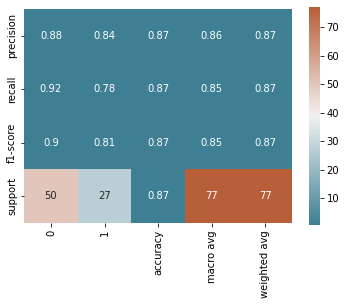

In [52]:
decision_tree_model, decision_tree_confusion = generate_DT_model(x_train, y_train,x_test, y_test,)

## Logistic Regression

In [53]:
def generate_LR_model(x_train, y_train,x_test, y_test, i=range(1, 60)):
    simplefilter("ignore", category=ConvergenceWarning)
    
    accuracy = []
    best_model, best_acc, besr_rs = None, (0,0), 'unknown'
    iters = list(i)
    
    for i in tqdm(iters, desc="Generating LR model", leave=False):
        model, acc, rs, y = find_best_random_state(LogisticRegression, x_train, y_train, x_test, y_test, max_iter=i)
        
        train_acc = acc[0]
        test_acc = acc[1]
        accuracy.append((train_acc, test_acc))
    
        if test_acc > best_acc[1] or (test_acc == best_acc[1] and train_acc > best_acc[0]) or best_model is None:
            best_acc = acc
            best_model = model
            I = i
            best_rs = rs
            Y = y
        
    simplefilter("always", category=ConvergenceWarning)
    plt.figure(figsize=(17,10))
    plt.title('Accuracy')
    plt.plot(iters, [acc[0] for acc in accuracy], label='Train')
    plt.plot(iters, [acc[1] for acc in accuracy], label='Test')
    plt.legend()
    plt.show()
    
    y_pred = Y
    print(F"Generated model statistic:")
    print(f"- train acc: {100*best_acc[0]:.1f}%")
    print(f"- test acc: {100*best_acc[1]:.1f}%")
    print(f"- recall: {100*recall_score(y_test, y_pred):.1f}%")
    print(f"- precision: {100*precision_score(y_test, y_pred):.1f}%")
    print(f"- f1: {100*f1_score(y_test, y_pred):.1f}%")
    print("Config:")
    print(f"- Max Iterations: {I}")
    print(f"- Random State: {best_rs}")
    
    confusion = confusion_matrix(y_test, y_pred)
    report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    sns.heatmap(
        report, 
        cmap=sns.diverging_palette(220, 25, as_cmap=True), 
        square=True,
        annot=True,
        robust=True,
        )
    return best_model, confusion

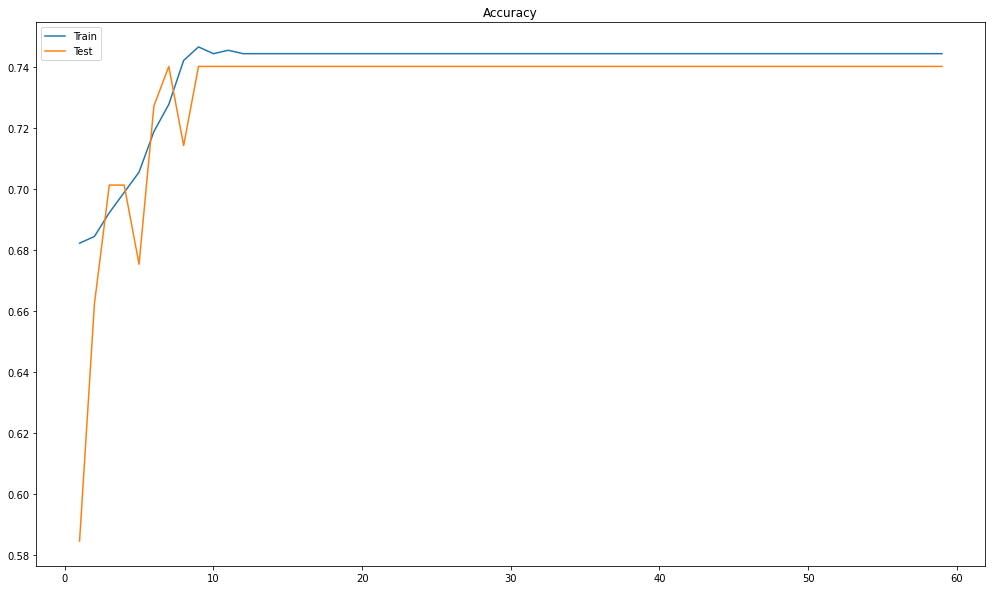

Generated model statistic:
- train acc: 74.7%
- test acc: 74.0%
- recall: 70.4%
- precision: 61.3%
- f1: 65.5%
Config:
- Max Iterations: 9
- Random State: 1


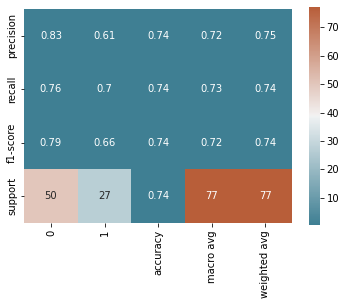

In [54]:
logistic_regression_model, logistic_regression_confusion = generate_LR_model(x_train, y_train,x_test, y_test)

## 01. evaluate model performance base of confusion matrix.

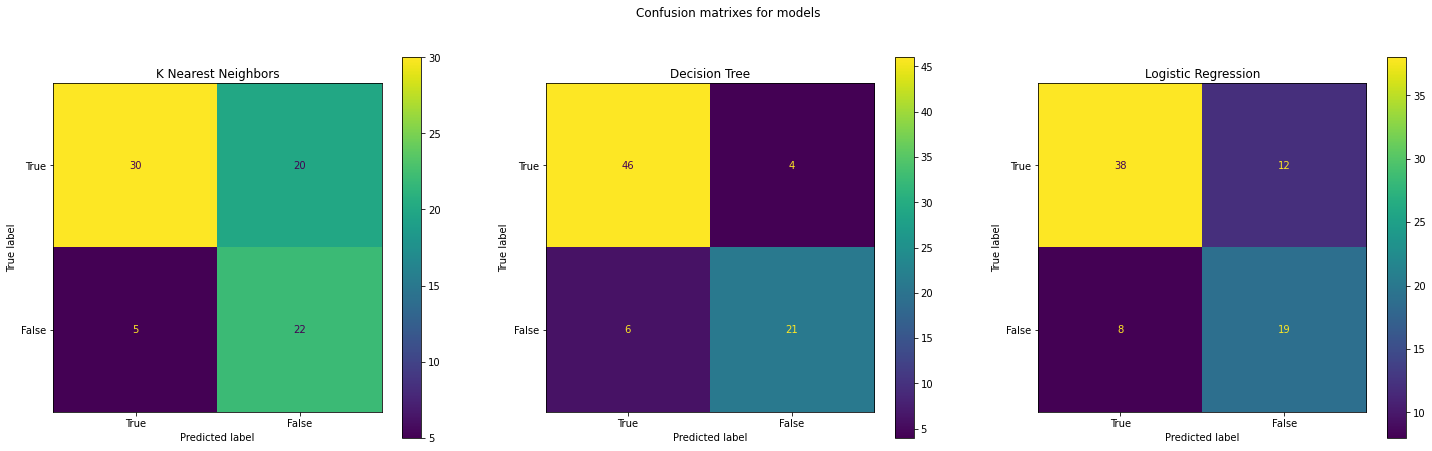

In [55]:
def display_confusion_matrix(**matrixes):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
    fig.suptitle(f"Confusion matrixes for models")
    i = 0
    for title, matrix in matrixes.items():
        cm = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['True', 'False'])
        ax[i].set_title(title.replace('_',' '))
        cm.plot(ax=ax[i])
        i = i + 1
        if i >= 3:
            break
    plt.show()

display_confusion_matrix(
    K_Nearest_Neighbors=knn_confusion,
    Decision_Tree=decision_tree_confusion,
    Logistic_Regression=logistic_regression_confusion
)

With the above confusion matrixes, we can fnd out that:
- KNN:
    - has the highest *true negative*
    - has the lowest *true positive*
    - has the highest *false negative*
    - has the lowest *false positive*
    - has the lowest accuracy
    - works better for samples with $Label=False$ or second row (not being diabetic)
    - $Stats=\{(TP=30),(FP=5),(TN=22),(FN=20)\}$
- DT:
    - has the highest *true positive*
    - has the lowest *false negative*
    - has the highest accuracy
    - works better for samples with $Label=True$ or first row (being diabetic)
    - $Stats=\{(TP=46),(FP=6),(TN=21),(FN=4)\}$
- LR:
    - has the lowest *true negative*
    - hs the highest *false positive*
    - $Stats=\{(TP=38),(FP=8),(TN=19),(FN=12)\}$

$Accuracy = \frac{TP+TN}{TP+FP+FN+TN}$:


$Precision = \frac{TP}{TP+FP}$:


$Recall = \frac{TP}{TP+FN}$:


$F1 Score = 2 * \frac{Recall * Precision}{Recall + Precision}$:

## Voting_model

That was not a good idea.

In [56]:
def voting_model(x_test, y_test, *models):
    
    threshold = len(models) // 2
    pred_result = models[0].predict(x_test)
    for model in models[1:]:
        p_res = model.predict(x_test)
        pred_result += p_res
    pred_result = pd.Series(pred_result)
    pred_result = pred_result.apply(lambda x: 1 if x >= threshold else 0)
    
    test_acc = accuracy_score(y_test, pred_result)
    print(f"Test accuracy for voting model: {100 * test_acc:.1f}")

voting_model(x_test, y_test, knn_model, decision_tree_model, logistic_regression_model)

Test accuracy for voting model: 64.9


## 02. find the optimum value for each parameter using GridSearchCV.

Grid Search: the process of performing hype-parameter tuning in order to determine the optimal values for a given model.
- $Grid Search + Cross Validation -> GridSearchCV$

In [57]:
def find_model_optimum_config(model: callable, grid_param: dict, x_data, y_data):
    optimum_knn_gs = GridSearchCV(
        estimator=model(),
        param_grid=grid_param,
        n_jobs=-1,
        cv=5,
    )
    grid_result = optimum_knn_gs.fit(x_data, y_data)
    best_params = grid_result.best_params_
    return best_params
    
def generate_costume_model(model: callable, config: dict, x_train, y_train):
    t_model = model(**config)
    t_model.fit(x_train, y_train)
    train_acc = accuracy_score(y_train, t_model.predict(x_train))
    return t_model, train_acc

In [58]:
def generate_optimum_knn(x_train, y_train,x_test, y_test):
    print("Generating optimum KNN model")
    param_grid={
        'n_neighbors': list(range(15,60,2)),
        'weights' : ['uniform', 'distance'],
        # 'algorithm' : ['auto', 'brute'],
        'leaf_size' : list(range(5,60,5)),
        'p': list(range(1,4)),
        'n_jobs': [-1]
        }
    best_params = find_model_optimum_config(KNeighborsClassifier, param_grid, x_train, y_train)
    print(f"- Optimum parameters:")
    for p, v in best_params.items():
        print(f"\t- {p} -> {v}")
        
    model, train_acc = generate_costume_model(KNeighborsClassifier, best_params, x_train, y_train)
    test_acc = accuracy_score(y_test, model.predict(x_test))
    
    print("- Statistics:")
    print(f"\t- train accuracy: {100*train_acc:.1f}%")
    print(f"\t- test accuracy: {100*test_acc:.1f}%")
    print()
    return model

In [59]:
def generate_optimum_dt(x_train, y_train,x_test, y_test):
    print("Generating optimum DecisionTree model")
    param_grid={
        'criterion' : ["gini", "entropy"],
        # 'splitter' : ["best", "random"],
        'max_depth': [None, *list(range(6, 41, 4))],
        'min_samples_split': list(range(2, 5)),
        'max_features' : ["sqrt", "log2", None],
        'max_leaf_nodes': [None, *list(range(14, 60, 10))],
        'min_samples_leaf': list(range(1, 24, 3)),
        'random_state': [1, 4],
        'min_impurity_decrease': [0.0, 0.05, 0.1],
        }
    best_params = find_model_optimum_config(DecisionTreeClassifier, param_grid, x_train, y_train)
    print(f"- Optimum parameters:")
    for p, v in best_params.items():
        print(f"\t- {p} -> {v}")
        
    model, train_acc = generate_costume_model(DecisionTreeClassifier, best_params, x_train, y_train)
    test_acc = accuracy_score(y_test, model.predict(x_test))
    
    print("- Statistics:")
    print(f"\t- train accuracy: {100*train_acc:.1f}%")
    print(f"\t- test accuracy: {100*test_acc:.1f}%")
    print()
    return model

In [60]:
def generate_optimum_lr(x_train, y_train, x_test, y_test):
    print("Generating optimum LogisticRegression model")
    solver_to_penalty= {
        'newton-cg': ['l2', None],
        'lbfgs': ['l2', None],
        'liblinear': ['l1', 'l2'],
        'sag': ['l2', None],
        'saga': ['l1', 'l2', None],
        'saga': ['elasticnet'],
        }
    base_param_grid={
        'penalty' : [None],
        'class_weight' : ['balanced', None],
        'solver' : [None],
        'max_iter' : list(range(15, 500, 20)), 
        'l1_ratio': [None], 
        }
    best_params = []
    simplefilter("ignore", category=ConvergenceWarning)
    for s, p in solver_to_penalty.items():
        param_grid = base_param_grid
        param_grid['solver'] = [s]
        param_grid['penalty'] = p
        if 'elasticnet' in p:
            base_param_grid['l1_ratio'] = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
        best_params.append(find_model_optimum_config(LogisticRegression, param_grid, x_train, y_train))
        
    best, acc = None, 0
    for config in best_params:
        model, train_acc = generate_costume_model(LogisticRegression, config, x_train, y_train)
        test_acc = accuracy_score(y_test, model.predict(x_test))
        _acc = (train_acc + test_acc) / 2
        if _acc > acc:
            acc = _acc
            best = config
        
    print(f"- Optimum parameters:")
    for p, v in best.items():
        print(f"\t- {p} -> {v}")
        
    model, train_acc = generate_costume_model(LogisticRegression, best, x_train, y_train)
    test_acc = accuracy_score(y_test, model.predict(x_test))
    simplefilter("always", category=ConvergenceWarning)
        
    print("- Statistics:")
    print(f"\t- train accuracy: {100*train_acc:.1f}%")
    print(f"\t- test accuracy: {100*test_acc:.1f}%")
    print()
    return model

In [61]:
optimum_knn = generate_optimum_knn(x_train, y_train,x_test, y_test)


Generating optimum KNN model
- Optimum parameters:
	- leaf_size -> 5
	- n_jobs -> -1
	- n_neighbors -> 15
	- p -> 1
	- weights -> distance
- Statistics:
	- train accuracy: 100.0%
	- test accuracy: 63.6%



In [67]:
optimum_tree = generate_optimum_dt(x_train, y_train,x_test, y_test)


Generating optimum DecisionTree model
- Optimum parameters:
	- criterion -> gini
	- max_depth -> 18
	- max_features -> log2
	- max_leaf_nodes -> None
	- min_impurity_decrease -> 0.0
	- min_samples_leaf -> 1
	- min_samples_split -> 4
	- random_state -> 1
- Statistics:
	- train accuracy: 96.7%
	- test accuracy: 72.7%



In [63]:
optimum_lr = generate_optimum_lr(x_train, y_train,x_test, y_test) 


Generating optimum LogisticRegression model
- Optimum parameters:
	- class_weight -> balanced
	- l1_ratio -> None
	- max_iter -> 15
	- penalty -> None
	- solver -> newton-cg
- Statistics:
	- train accuracy: 75.8%
	- test accuracy: 75.3%



## 03. explain underfitting and overfitting. have they happened in your model?

1. overfitting:
    - occurs when a model performs really well on the train data, but it fails to generalise well to unseen data.
    - it could be due to the noise in data or it could be that the model learned to predict specific inputs rather than setting parameters that could help it make better predictions.
    - the chance of overfitting, has positive correlation with complexity of a model
2. underfitting:
    - occurs when the model has poor performance even on the train data.
    - usually, it occurs because the model is not suitable for that problem you are trying to solve; which means that the model is less complex than required.

Using test set, we can check whether these have occurred or not. for example, if training accuracy is extremely high, but the testing accuracy is poor, it would be a good sign of overfitting.

- In our model generating function, as it is clear, we tried to avoid both of them.
- As we can see from model's statistics, overfitting is very likely for KNN and maybe DT but not LR.
- Models that generated using GridSearch, overfitting happened except for Logistic Regression

## 04. try to improve your model performance by make changes into preprocessing. 

As we can get our best result with Decision Tree model, we would only work with that in this section.

### Outliers

By examining data, there are some noises in our dataset like negative values for [`Age`, `Pregnancies`, `Glucose`, `BloodPressure`].
We can delete noisy data or just replace noise values with *Nan*.

We try to remove outliers.

Result:
- although, we need to take care of noises, but out approach wasn't a really good way, but it worked
- it is clear that we could get higher accuracy from DT, but regarding to it's acc-score plot, it couldn't really improve model

In [36]:
def outlier_to_nan(_df: pd.DataFrame, cols: list[str]):
    df = _df.copy(deep=True)
    for col in cols:
        ranges = sorted(list(df[col].quantile(q=[0.005,0.9]).values))
        df[col] = df[col].apply(lambda x: np.NaN if x and (x < ranges[0] or x > ranges[1]) else x)
    return df


In [37]:
new_df = outlier_to_nan(diabetes,['Age', 'BloodPressure', 'Glucose', 'Pregnancies'])
new_lost = get_lost_values(new_df)
new_nan_fixed = solve_missing_values(new_df, new_lost)
new_standardized = standardize_df(new_nan_fixed, restricted=['Outcome'])

new_training_data, new_testing_data = train_test_split(new_standardized, test_size=TEST_PORTION, random_state=42, stratify=new_standardized['Outcome'])
x_train_n, y_train_n = new_training_data.drop(columns=['Outcome'], axis=1), new_training_data['Outcome']
x_test_n, y_test_n = new_testing_data.drop(columns=['Outcome'], axis=1), new_testing_data['Outcome']


outlier_models = dict()

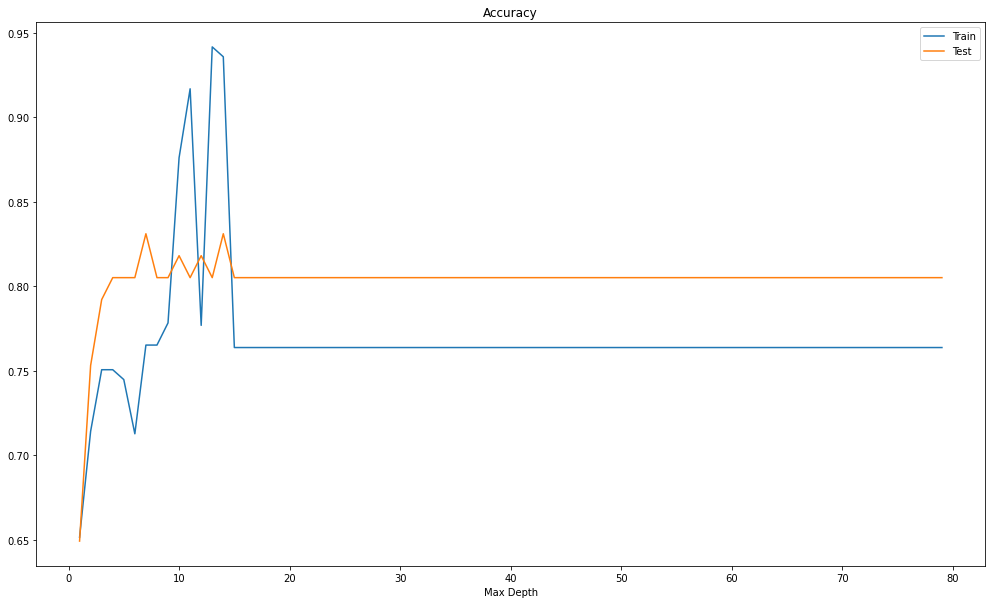

Generated model statistic:
- train acc: 93.6%
- test acc: 83.1%
- recall: 70.4%
- precision: 79.2%
- f1: 74.5%
Config:
- Max Depth: 14
- Min Samples Leaf: unknown
- Random State: 17
- Min Impurity Decrease: default
- Feature selection: None


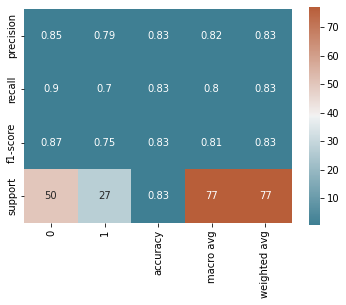

In [70]:
_ = generate_DT_model(x_train_n, y_train_n, x_test_n, y_test_n)

#### KNN

In [71]:
outlier_models['KNN'] = generate_optimum_knn(x_train_n, y_train_n, x_test_n, y_test_n)


Generating optimum KNN model


c:\Users\pouya\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


- Optimum parameters:
	- leaf_size -> 5
	- n_jobs -> -1
	- n_neighbors -> 25
	- p -> 1
	- weights -> distance
- Statistics:
	- train accuracy: 100.0%
	- test accuracy: 70.1%



#### Decision Tree

In [72]:
outlier_models['DT'] = generate_optimum_dt(x_train_n, y_train_n, x_test_n, y_test_n)


Generating optimum DecisionTree model
- Optimum parameters:
	- criterion -> entropy
	- max_depth -> 6
	- max_features -> None
	- max_leaf_nodes -> None
	- min_impurity_decrease -> 0.0
	- min_samples_leaf -> 19
	- min_samples_split -> 2
	- random_state -> 1
- Statistics:
	- train accuracy: 75.7%
	- test accuracy: 74.0%



#### Logistic Regression

In [73]:
outlier_models['LR'] = generate_optimum_lr(x_train_n, y_train_n, x_test_n, y_test_n)


Generating optimum LogisticRegression model
- Optimum parameters:
	- class_weight -> None
	- l1_ratio -> None
	- max_iter -> 15
	- penalty -> l1
	- solver -> liblinear
- Statistics:
	- train accuracy: 75.1%
	- test accuracy: 70.1%



### Prune dataset (F.E.)

In this part, we want to drop some columns with lower correlation with outcome and only use the one with high correlation.

Result:
- this is a good approach and worked well but there is an important point
- this approach couldn't improve our models performance


In [74]:
poor_corr = [
    feature for correlation, feature in zip(corr['Outcome'], corr['Outcome'].index) 
    if correlation <= 0.15 and feature != 'Outcome'
    ]

pruned_training, prune_testing = training_data.drop(columns=poor_corr, axis=1), testing_data.drop(columns=poor_corr, axis=1)
x_train_p, y_train_p = pruned_training.drop(columns=['Outcome'], axis=1), pruned_training['Outcome']
x_test_p, y_test_p = prune_testing.drop(columns=['Outcome'], axis=1), prune_testing['Outcome']

prune_models = dict()

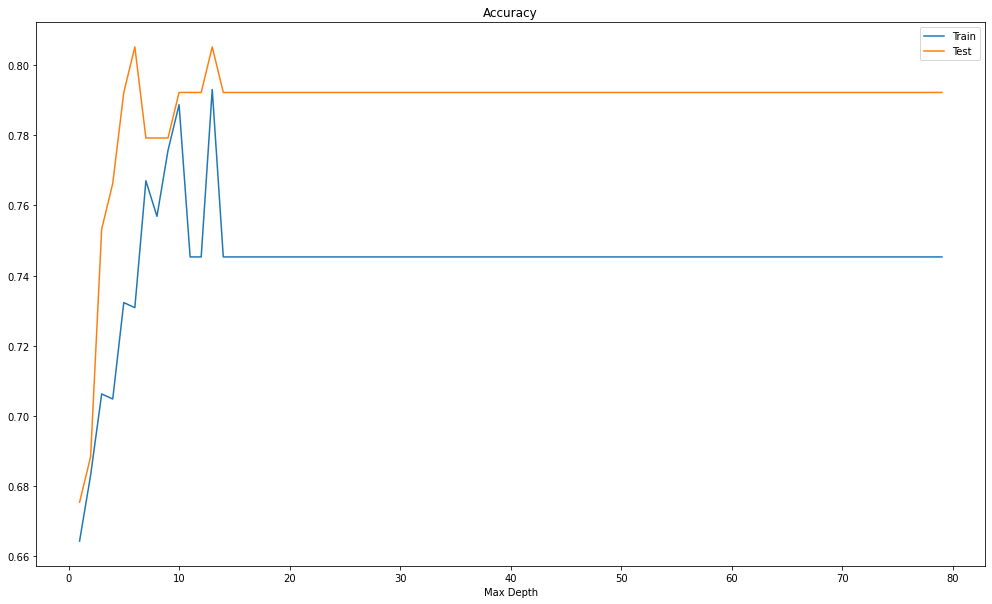

Generated model statistic:
- train acc: 79.3%
- test acc: 80.5%
- recall: 70.4%
- precision: 73.1%
- f1: 71.7%
Config:
- Max Depth: 13
- Min Samples Leaf: 7
- Random State: 4
- Min Impurity Decrease: default
- Feature selection: sqrt


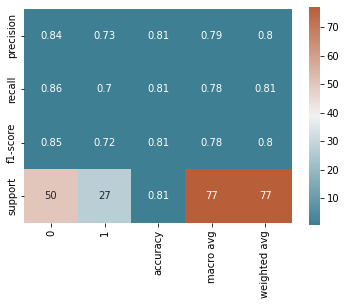

In [75]:
_ = generate_DT_model(x_train_p, y_train_p, x_test_p, y_test_p)

#### KNN

In [78]:
prune_models['KNN'] = generate_optimum_knn(x_train_p, y_train_p, x_test_p, y_test_p)

Generating optimum KNN model
- Optimum parameters:
	- leaf_size -> 5
	- n_jobs -> -1
	- n_neighbors -> 35
	- p -> 1
	- weights -> uniform
- Statistics:
	- train accuracy: 71.5%
	- test accuracy: 70.1%



#### Decision Tree

In [79]:
prune_models['DT'] = generate_optimum_dt(x_train_p, y_train_p, x_test_p, y_test_p)

Generating optimum DecisionTree model
- Optimum parameters:
	- criterion -> gini
	- max_depth -> 6
	- max_features -> sqrt
	- max_leaf_nodes -> 14
	- min_impurity_decrease -> 0.0
	- min_samples_leaf -> 19
	- min_samples_split -> 2
	- random_state -> 1
- Statistics:
	- train accuracy: 73.2%
	- test accuracy: 75.3%



#### Logistic Regression

In [80]:
prune_models['LR'] = generate_optimum_lr(x_train_p, y_train_p, x_test_p, y_test_p)

Generating optimum LogisticRegression model
- Optimum parameters:
	- class_weight -> None
	- l1_ratio -> None
	- max_iter -> 15
	- penalty -> l2
	- solver -> newton-cg
- Statistics:
	- train accuracy: 69.9%
	- test accuracy: 70.1%



### Under Sampling

Due to imbalance dataset, we used over-sampling, but what if we used under-sampling?
- out models accuracy decreased in this case.

In [81]:
u_training_data, u_testing_data = train_test_split(diabetes_standardized, test_size=TEST_PORTION, random_state=11, stratify=diabetes_standardized['Outcome'])

x_train_u, y_train_u = u_training_data.drop(columns=['Outcome'], axis=1), u_training_data['Outcome']
x_test_u, y_test_u = u_testing_data.drop(columns=['Outcome'], axis=1), u_testing_data['Outcome']

nr = NearMiss()
X_train_miss, y_train_miss = nr.fit_resample(x_train_u, y_train_u.ravel())

under_sampled_models = dict()

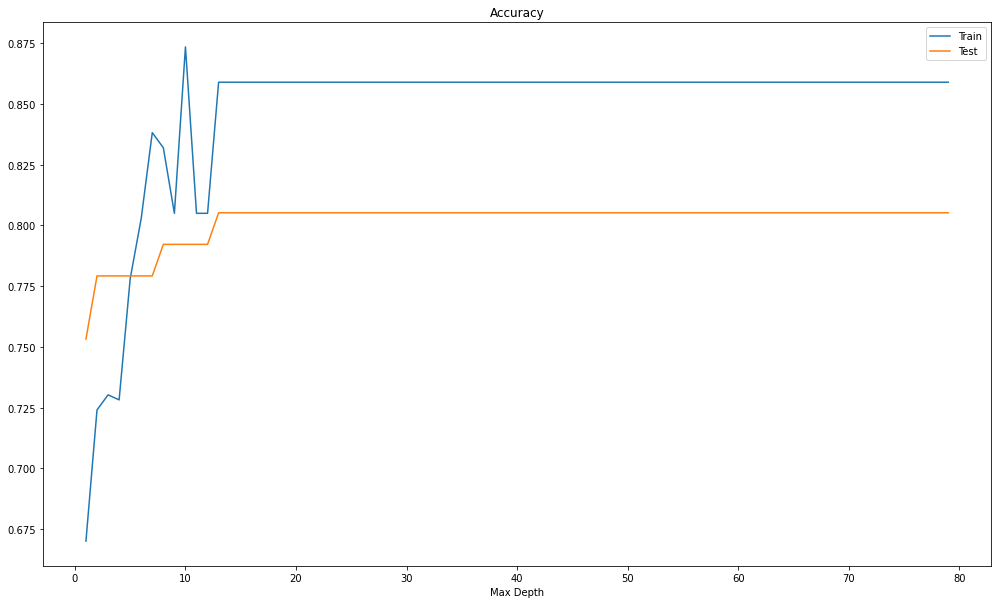

Generated model statistic:
- train acc: 85.9%
- test acc: 80.5%
- recall: 85.2%
- precision: 67.6%
- f1: 75.4%
Config:
- Max Depth: 13
- Min Samples Leaf: 7
- Random State: 4
- Min Impurity Decrease: default
- Feature selection: log2


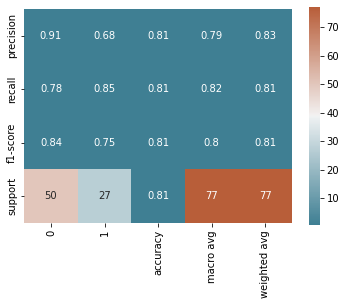

In [82]:
_ = generate_DT_model(X_train_miss, y_train_miss, x_test_u, y_test_u)

#### KNN

In [83]:
under_sampled_models['KNN'] = generate_optimum_knn(X_train_miss, y_train_miss, x_test_u, y_test_u)

Generating optimum KNN model


c:\Users\pouya\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


- Optimum parameters:
	- leaf_size -> 5
	- n_jobs -> -1
	- n_neighbors -> 19
	- p -> 3
	- weights -> uniform
- Statistics:
	- train accuracy: 73.9%
	- test accuracy: 64.9%



#### Decision Tree

In [84]:
under_sampled_models['DT'] = generate_optimum_dt(X_train_miss, y_train_miss, x_test_u, y_test_u)

Generating optimum DecisionTree model
- Optimum parameters:
	- criterion -> gini
	- max_depth -> None
	- max_features -> None
	- max_leaf_nodes -> 14
	- min_impurity_decrease -> 0.0
	- min_samples_leaf -> 4
	- min_samples_split -> 2
	- random_state -> 1
- Statistics:
	- train accuracy: 83.2%
	- test accuracy: 75.3%



#### Logistic Regression

In [85]:
under_sampled_models['LR'] = generate_optimum_lr(X_train_miss, y_train_miss, x_test_u, y_test_u)

Generating optimum LogisticRegression model
- Optimum parameters:
	- class_weight -> balanced
	- l1_ratio -> None
	- max_iter -> 15
	- penalty -> l1
	- solver -> liblinear
- Statistics:
	- train accuracy: 79.7%
	- test accuracy: 72.7%



# Phase 4: Ensemble Learning

## Parameters

- n_estimators: number of trees in the forest:
    - Generally, increasing this value won't hurt accuracy (on train value), but very high numbers could cause overfitting
    - Increasing this value, could slow-down our model
     
     
- max_depth: maximum depth of the tree:
    - Works as it did on DecisionTree
    - High values, could lead to overfitting


- min_samples_leaf: the minimum number of samples required to be at a leaf node:
    - using this parameter, we can avoid overfitting and underfitting


In [38]:
def generate_RF_model(
    x_train, y_train, x_test, y_test, 
    estimators=range(1,200,2), m_depth=range(1, 61),
    leafs=range(1, 61)):
    n_estimators = list(estimators)
    max_depth = list(m_depth)
    leaf_nodes = list(leafs)
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(40, 15))
    
    best_model, best_model_acc, best_config = None, [0,0], None
    best_model, acc, rs, y = find_best_random_state(RandomForestClassifier,
                                                x_train, y_train, x_test, y_test, 
                                                n_jobs=-1, criterion="entropy",
                                                states=range(1,10))
    best_config = ('unknown', 'unknown', rs)
    best_model_acc = [acc[1], acc[0]]
    
    ax[0][0].set_title('#Estimators effect')
    train_acc, test_acc = [], []
    best_e, best_acc_mean = 1, 0
    Y = y
    for n_e in tqdm(n_estimators, leave=False, desc='Generating RF model, phase 1'):
        model, acc, rs, y = find_best_random_state(RandomForestClassifier, 
                                                x_train, y_train, x_test, y_test, 
                                                n_estimators=n_e, n_jobs=-1, criterion="entropy", 
                                                states=range(1,10))
        train_acc.append(acc[0])
        test_acc.append(acc[1])
        acc_mean = (train_acc[-1] + test_acc[-1]) / 2
        if acc_mean > best_acc_mean:
            best_e = n_e
            best_acc_mean = acc_mean
        if test_acc[-1] > best_model_acc[0]:
            best_model_acc[0] = test_acc[-1]
            best_model_acc[1] = train_acc[-1]
            best_model = model
            best_config = (n_e, 'unknown', rs, 'unknown')
            Y = y
    ax[0][0].plot(n_estimators, train_acc, label='Train Acc')
    ax[0][0].plot(n_estimators, test_acc, label='Test Acc')
    ax[0][0].set_xlabel('Number of estimators')
    ax[0][0].set_ylabel('Accuracy')
    ax[0][0].legend()
    
    ax[0][1].set_title('MaxDepth effect')
    train_acc, test_acc = [], []
    best_d, best_acc_mean = 1, 0
    for d in tqdm(max_depth, leave=False, desc='Generating RF model, phase 2'):
        model, acc, rs, y = find_best_random_state(RandomForestClassifier, 
                                                x_train, y_train, x_test, y_test,
                                                max_depth=d, n_jobs=-1, criterion="entropy", 
                                                states=range(1,10))
        train_acc.append(acc[0])
        test_acc.append(acc[1])
        acc_mean = (train_acc[-1] + test_acc[-1]) / 2
        if acc_mean > best_acc_mean:
            best_d = d
            best_acc_mean = acc_mean
        if test_acc[-1] > best_model_acc[0]:
            best_model_acc[0] = test_acc[-1]
            best_model_acc[1] = train_acc[-1]
            best_model = model
            best_config = ('unknown', d, rs, 'unknown')
            Y = y
    ax[0][1].plot(max_depth, train_acc, label='Train Acc')
    ax[0][1].plot(max_depth, test_acc, label='Test Acc')
    ax[0][1].set_xlabel('Max depth')
    ax[0][1].set_ylabel('Accuracy')
    ax[0][1].legend()
    
    
    ax[1][0].set_title(f'#Estimators effect on depth={best_d}')
    train_acc, test_acc = [], []
    for n_e in tqdm(n_estimators, leave=False, desc='Generating RF model, phase 3'):
        model, acc, rs, y = find_best_random_state(RandomForestClassifier, 
                                                x_train, y_train, x_test, y_test,
                                                n_estimators=n_e, max_depth=best_d, n_jobs=-1, criterion="entropy", 
                                                states=range(1,10))
        train_acc.append(acc[0])
        test_acc.append(acc[1])
        if test_acc[-1] > best_model_acc[0]:
            best_model_acc[0] = test_acc[-1]
            best_model_acc[1] = train_acc[-1]
            best_model = model
            best_config = (n_e, best_d, rs, 'unknown')
            Y = y
    ax[1][0].plot(n_estimators, train_acc, label='Train Acc')
    ax[1][0].plot(n_estimators, test_acc, label='Test Acc')
    ax[1][0].set_xlabel('Number of estimators')
    ax[1][0].set_ylabel('Accuracy')
    ax[1][0].legend()
    
    ax[1][1].set_title(f'MaxDepth effect with {best_e} estimators')
    train_acc, test_acc = [], []
    for d in tqdm(max_depth, leave=False, desc='Generating RF model, phase 4'):
        model, acc, rs, y = find_best_random_state(RandomForestClassifier, 
                                                x_train, y_train, x_test, y_test, 
                                                n_estimators=n_e, max_depth=d, n_jobs=-1, criterion="entropy", 
                                                states=range(1,10))
        train_acc.append(acc[0])
        test_acc.append(acc[1])
        if test_acc[-1] > best_model_acc[0]:
            best_model_acc[0] = test_acc[-1]
            best_model_acc[1] = train_acc[-1]
            best_model = model
            best_config = (best_e, d, rs,'unknown')
            Y = y
    ax[1][1].plot(max_depth, train_acc, label='Train Acc')
    ax[1][1].plot(max_depth, test_acc, label='Test Acc')
    ax[1][1].set_xlabel('Max depth')
    ax[1][1].set_ylabel('Accuracy')
    ax[1][1].legend()
    
    ax[2][0].set_title(f'MinSamples effect')
    train_acc, test_acc = [], []
    for l in tqdm(leaf_nodes, leave=False, desc='Generating RF model, phase 6'):
        model, acc, rs, y = find_best_random_state(RandomForestClassifier, 
                                                x_train, y_train, x_test, y_test, 
                                                n_jobs=-1, min_samples_leaf=l, criterion="entropy", 
                                                states=range(1,10))
        train_acc.append(acc[0])
        test_acc.append(acc[1])
        if test_acc[-1] > best_model_acc[0]:
            best_model_acc[0] = test_acc[-1]
            best_model_acc[1] = train_acc[-1]
            best_model = model
            best_config = (best_e, best_d, rs, l)
            Y = y
    ax[2][0].plot(leaf_nodes, train_acc, label='Train Acc')
    ax[2][0].plot(leaf_nodes, test_acc, label='Test Acc')
    ax[2][0].set_xlabel('Max depth')
    ax[2][0].set_ylabel('Accuracy')
    ax[2][0].legend()
    
    ax[2][1].set_title(f'MinSamples effect with {best_e} estimators and depth={best_d}')
    train_acc, test_acc = [], []
    for l in tqdm(leaf_nodes, leave=False, desc='Generating RF model, phase 6'):
        model, acc, rs, y = find_best_random_state(RandomForestClassifier, 
                                                x_train, y_train, x_test, y_test, 
                                                n_estimators=n_e, max_depth=d, n_jobs=-1, 
                                                min_samples_leaf=l, criterion="entropy", 
                                                states=range(1,10))
        train_acc.append(acc[0])
        test_acc.append(acc[1])
        if test_acc[-1] > best_model_acc[0]:
            best_model_acc[0] = test_acc[-1]
            best_model_acc[1] = train_acc[-1]
            best_model = model
            best_config = (best_e, best_d, rs, l)
            Y = y
    ax[2][1].plot(leaf_nodes, train_acc, label='Train Acc')
    ax[2][1].plot(leaf_nodes, test_acc, label='Test Acc')
    ax[2][1].set_xlabel('Max depth')
    ax[2][1].set_ylabel('Accuracy')
    ax[2][1].legend()
    
    plt.show()
    y_pred = Y
    
    print("The best Random Forest model generated Statistics:")
    print(f"- train acc: {100*best_model_acc[1]:.1f}%")
    print(f"- test acc: {100*best_model_acc[0]:.1f}%")
    print(f"- mean acc: {100*((best_model_acc[0] + best_model_acc[1]) / 2):.1f}%")
    print(f"- acc gap: {100*abs(best_model_acc[0] - best_model_acc[1]):.1f}%")
    print(f"- recall: {100*recall_score(y_test, y_pred, average='macro'):.1f}%")
    print(f"- precision: {100*precision_score(y_test, y_pred, average='macro'):.1f}%")
    print(f"- f1: {100*f1_score(y_test, y_pred, average='macro'):.1f}%")
    print('Config:')
    print(f'- number of estimators: {best_config[0]}')
    print(f'- max depth: {best_config[1]}')
    print(f'- random state: {best_config[2]}')
    print(f'- min sample leaf: {best_config[3]}')
    
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,10))
    ConfusionMatrixDisplay(conf_mat, display_labels=best_model.classes_).plot()
    plt.show()
    
    return best_model
    

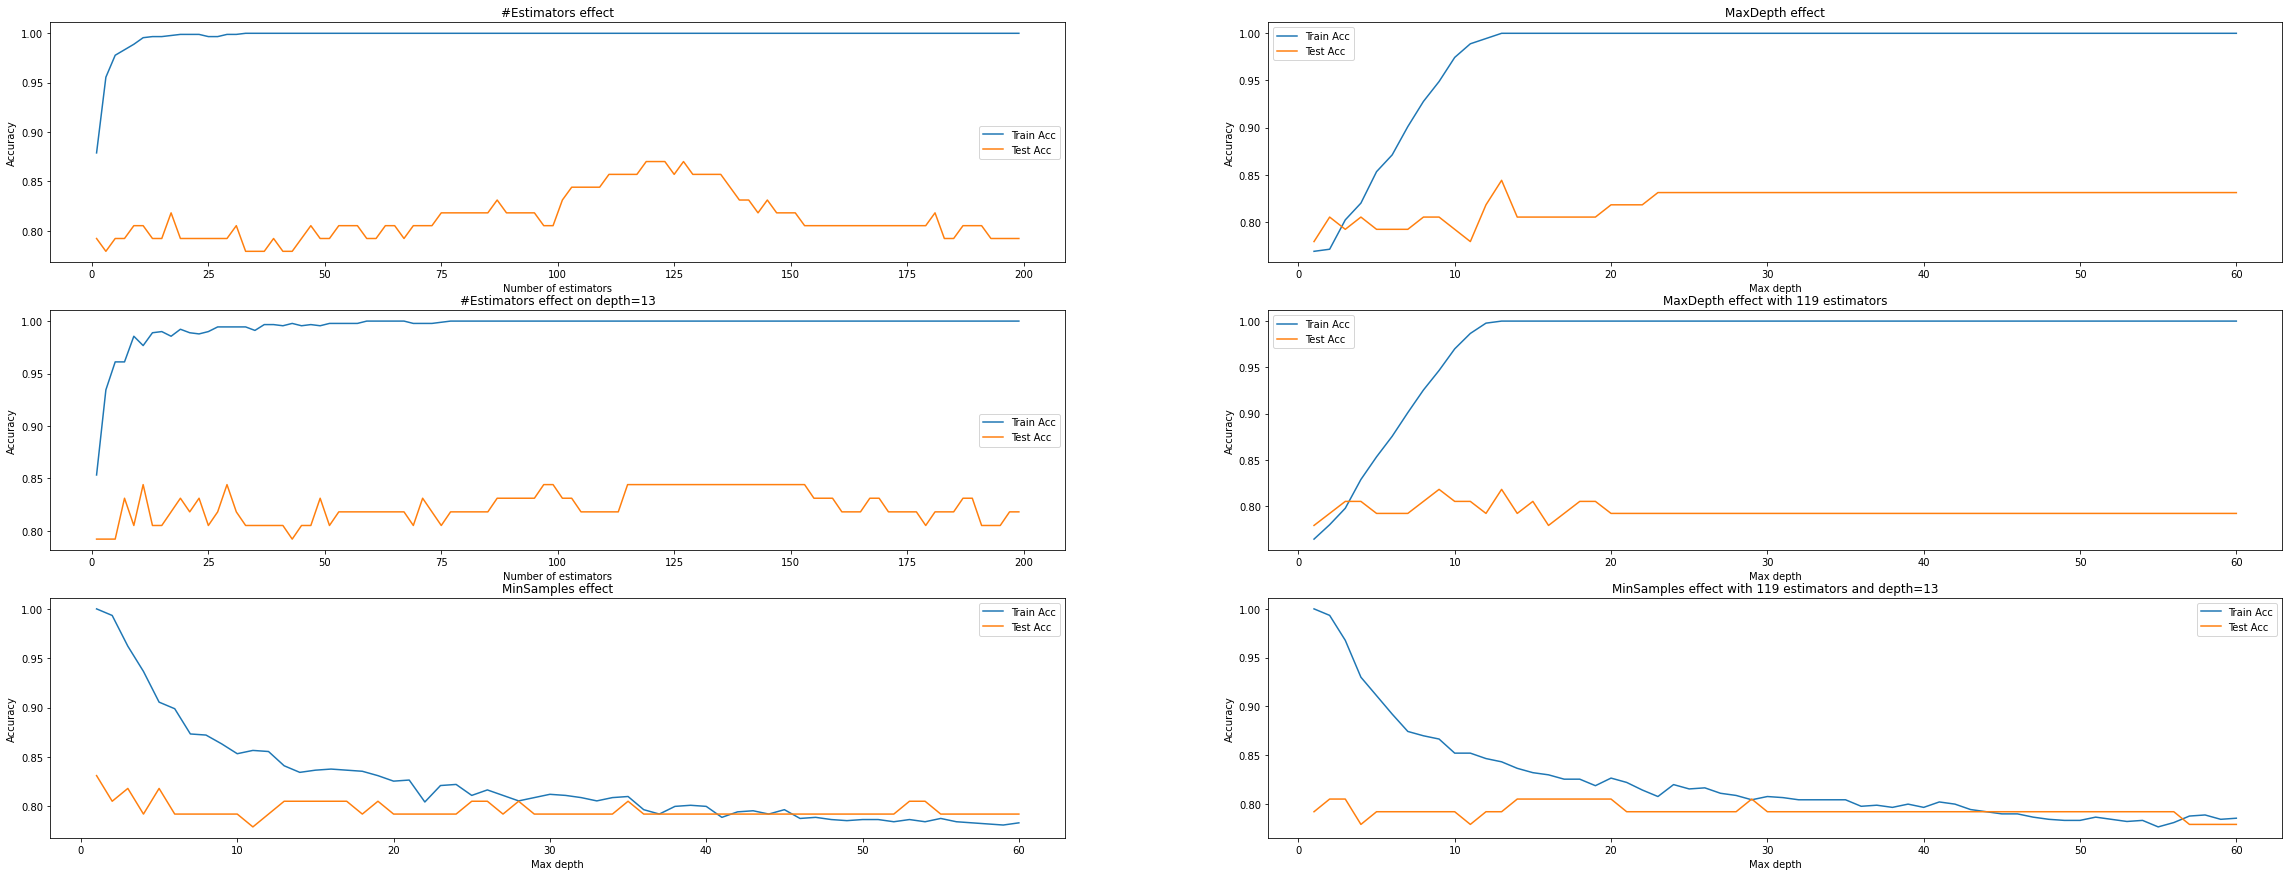

The best Random Forest model generated Statistics:
- train acc: 100.0%
- test acc: 87.0%
- mean acc: 93.5%
- acc gap: 13.0%
- recall: 86.6%
- precision: 85.5%
- f1: 86.0%
Config:
- number of estimators: 119
- max depth: unknown
- random state: 4
- min sample leaf: unknown


<Figure size 720x720 with 0 Axes>

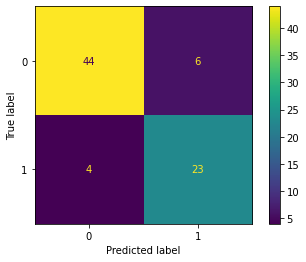

In [39]:
random_forest_model = generate_RF_model(x_train, y_train, x_test, y_test)

Generate model using noiseless data

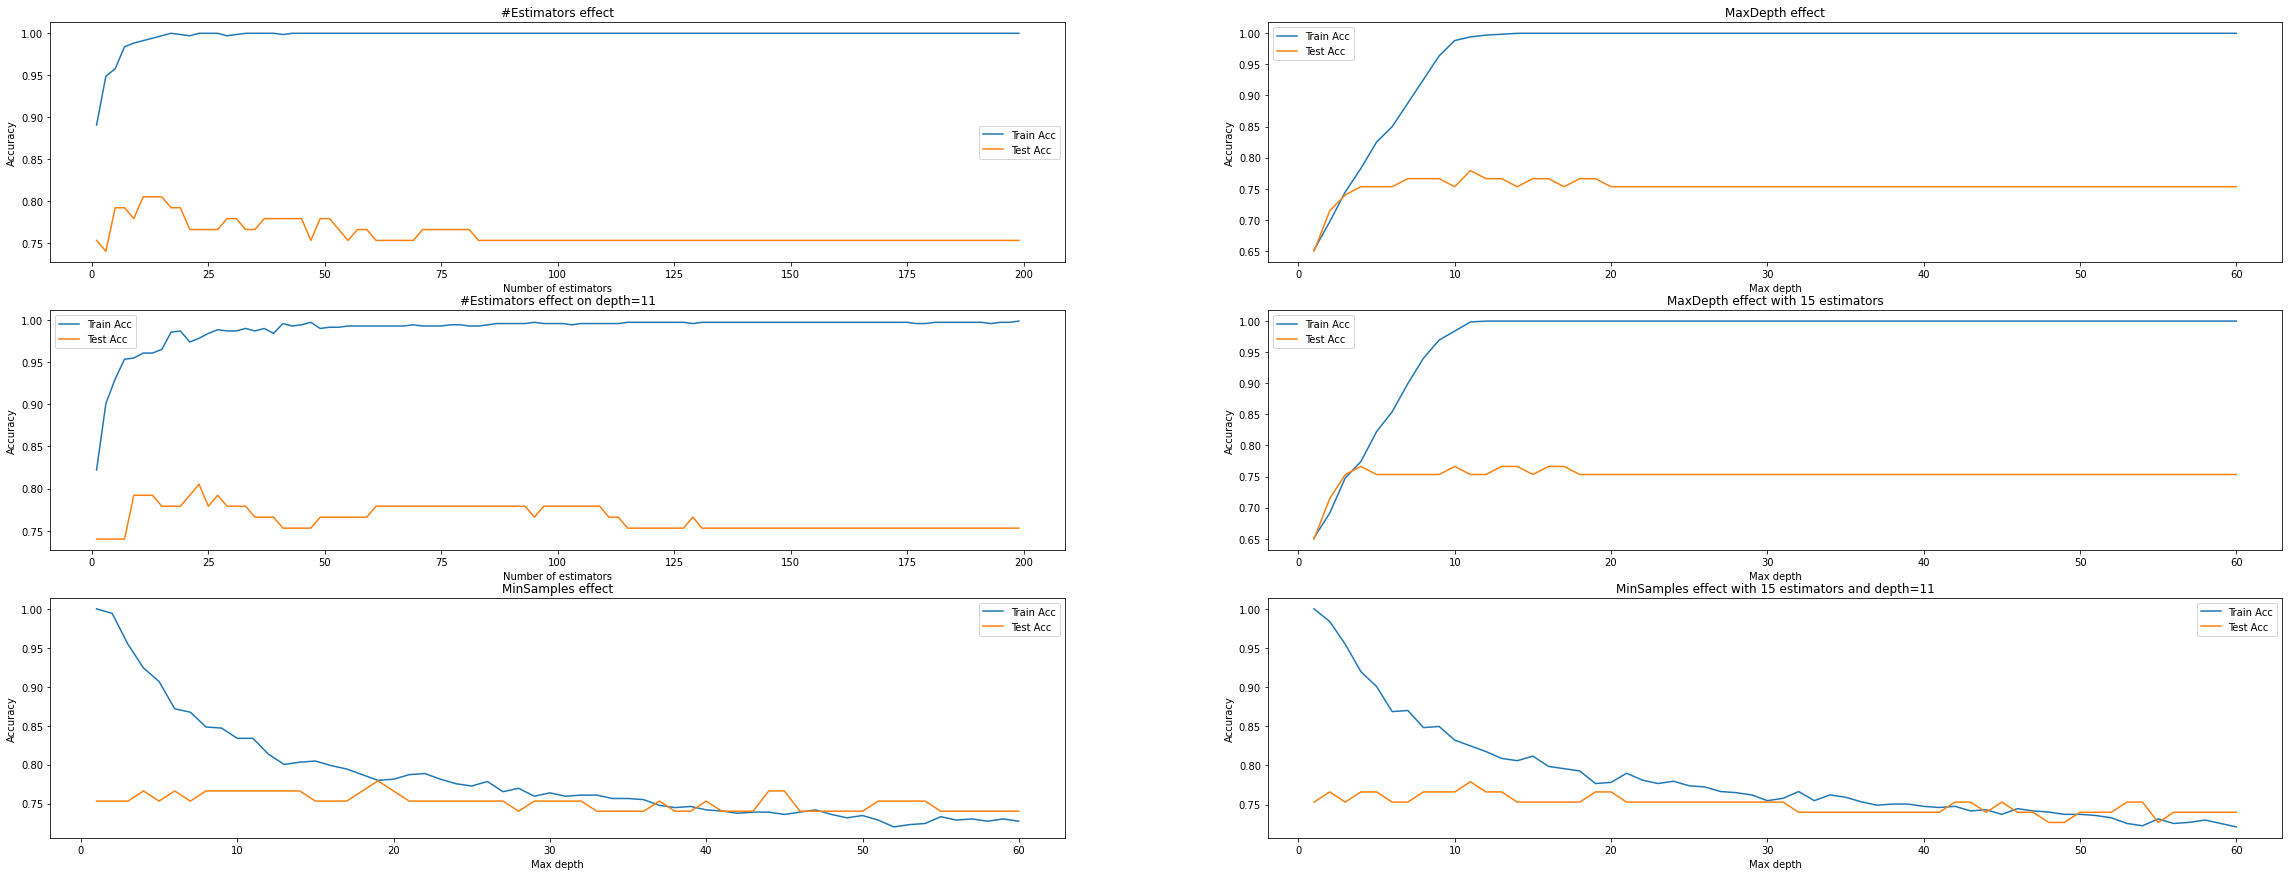

The best Random Forest model generated Statistics:
- train acc: 99.1%
- test acc: 80.5%
- mean acc: 89.8%
- acc gap: 18.6%
- recall: 75.6%
- precision: 80.4%
- f1: 77.0%
Config:
- number of estimators: 11
- max depth: unknown
- random state: 9
- min sample leaf: unknown


<Figure size 720x720 with 0 Axes>

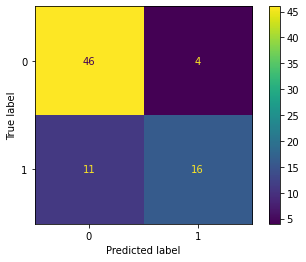

In [40]:
_ = generate_RF_model(x_train_n, y_train_n, x_test_n, y_test_n)

## Build model

This time, we use GridSearch to config our model.

In [114]:
def generate_optimum_rf(x_train, y_train, x_test, y_test):
    print("Generating optimum Random Forest model")
    param_grid={
        'n_estimators': [*list(range(13,33, 2)), *list(range(35,200, 20))],
        'max_depth': [None, *list(range(10,22,3)), *list(range(22,60, 15))],
        'min_samples_split': list(range(2,8,2)),
        # 'max_features': ["auto", None, "log2"],
        'warm_start': [True, False],
        'n_jobs': [-1],
        # 'max_samples': [None, 0.1, 0.2, 0.4],
        'min_samples_leaf': list(range(1, 24, 3)),
        'random_state': [1, 3, 4],
        }
    best_params = find_model_optimum_config(RandomForestClassifier, param_grid, x_train, y_train)
    print(f"- Optimum parameters:")
    for p, v in best_params.items():
        print(f"\t- {p} -> {v}")
        
    model, train_acc = generate_costume_model(RandomForestClassifier, best_params, x_train, y_train)
    test_acc = accuracy_score(y_test, model.predict(x_test))
    
    print("- Statistics:")
    print(f"\t- train accuracy: {100*train_acc:.1f}%")
    print(f"\t- test accuracy: {100*test_acc:.1f}%")
    print()
    return model

In [116]:
optimum_rf = generate_optimum_rf(x_train, y_train, x_test, y_test )

Generating optimum Random Forest model


c:\Users\pouya\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


- Optimum parameters:
	- max_depth -> 13
	- min_samples_leaf -> 1
	- min_samples_split -> 2
	- n_estimators -> 135
	- n_jobs -> -1
	- random_state -> 3
	- warm_start -> True
- Statistics:
	- train accuracy: 100.0%
	- test accuracy: 76.6%



## Compare RandomForest and DecisionTree

There is a trade off between bias and variance:
- DecisionTree: by increasing tree's depth, variance would increase.
- RandomForest tries to reduce variance by bagging, also has the same bias as a single decision tree.
- In general, RandomForest would have lower variance than Decision tree and also prevent bias increment in this tradeoff. 
- So, in general, we expect better performance from RF.
- As we can see, our result and plots could prove this(check Recall, Precision, and F1-score for each model).

***
- As a result of using Bagging, RandomForest has lower variance than DecisionTree. 
- Because of small dataset, higher bias is reasonable (we tried to avoid using oversampling).
